In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Loading TextBlob Sentiment Analysis Data and BERTopic Data

In [3]:
text_blob_df = pd.read_csv('data/sentiment_analysis_textblob.csv')

print(text_blob_df.head())

                                            filename source_type  \
0  data/podcasts/armchair-expert-with-dax-shepard...     podcast   
1  data/podcasts/armchair-expert-with-dax-shepard...     podcast   
2  data/podcasts/armchair-expert-with-dax-shepard...     podcast   
3  data/podcasts/armchair-expert-with-dax-shepard...     podcast   
4  data/podcasts/armchair-expert-with-dax-shepard...     podcast   

                        source_name  \
0  Armchair Expert With Dax Shepard   
1  Armchair Expert With Dax Shepard   
2  Armchair Expert With Dax Shepard   
3  Armchair Expert With Dax Shepard   
4  Armchair Expert With Dax Shepard   

                                               title publish_date  chunk_id  \
0  Acquired Podcast on the NFL (with Ben Gilbert ...   2025-02-05         0   
1  Acquired Podcast on the NFL (with Ben Gilbert ...   2025-02-05         1   
2  Acquired Podcast on the NFL (with Ben Gilbert ...   2025-02-05         2   
3  Acquired Podcast on the NFL (with Ben

In [11]:
topics_df = pd.read_csv('bertopic_results_with_topics.csv')


#topics_df = topics_df[['filename', 'title', 'chunk_id', 'topic']]

topics_news = topics_df[topics_df['source_type'] == 'news']

print(topics_news.head())



                                           filename source_type source_name  \
352071  data/article data/NPR/combined_npr_news.pkl        news         NPR   
352072  data/article data/NPR/combined_npr_news.pkl        news         NPR   
352073  data/article data/NPR/combined_npr_news.pkl        news         NPR   
352074  data/article data/NPR/combined_npr_news.pkl        news         NPR   
352075  data/article data/NPR/combined_npr_news.pkl        news         NPR   

                                                    title publish_date  \
352071  Norovirus outbreaks are on the rise around the...   2025-01-01   
352072  Norovirus outbreaks are on the rise around the...   2025-01-01   
352073  Cutting out alcohol for Dry January? These app...   2025-01-03   
352074  Cutting out alcohol for Dry January? These app...   2025-01-03   
352075  Cutting out alcohol for Dry January? These app...   2025-01-03   

        chunk_id                                               text topic  \
352

/var/folders/n3/kz2gn60507b7b477xltg2qpc0000gn/T/ipykernel_13761/3185227359.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  topics_df = pd.read_csv('bertopic_results_with_topics.csv')


In [5]:
text_blob_df_no_topic = text_blob_df.drop('topic', axis=1)

text_blob_df = text_blob_df_no_topic.merge(
    topics_df[['filename', 'title', 'chunk_id', 'topic']], 
    on=['filename', 'title', 'chunk_id'], 
    how='left')

print(text_blob_df.head())

                                            filename source_type  \
0  data/podcasts/armchair-expert-with-dax-shepard...     podcast   
1  data/podcasts/armchair-expert-with-dax-shepard...     podcast   
2  data/podcasts/armchair-expert-with-dax-shepard...     podcast   
3  data/podcasts/armchair-expert-with-dax-shepard...     podcast   
4  data/podcasts/armchair-expert-with-dax-shepard...     podcast   

                        source_name  \
0  Armchair Expert With Dax Shepard   
1  Armchair Expert With Dax Shepard   
2  Armchair Expert With Dax Shepard   
3  Armchair Expert With Dax Shepard   
4  Armchair Expert With Dax Shepard   

                                               title publish_date  chunk_id  \
0  Acquired Podcast on the NFL (with Ben Gilbert ...   2025-02-05         0   
1  Acquired Podcast on the NFL (with Ben Gilbert ...   2025-02-05         1   
2  Acquired Podcast on the NFL (with Ben Gilbert ...   2025-02-05         2   
3  Acquired Podcast on the NFL (with Ben

## Return Topic Words For Diverging Stacked Bar Chart

In [ ]:

def get_highest_prob_word(topic_list):
    if not topic_list or topic_list == '[]' or pd.isna(topic_list):
        return None
    
    
    if isinstance(topic_list, str):
        try:
            topic_list = eval(topic_list)
        except:
            return None
    
    if topic_list:
        max_tuple = max(topic_list, key=lambda x: x[1])
        return max_tuple[0]  
    
    return None

text_blob_df['topic_word'] = text_blob_df['topic'].apply(get_highest_prob_word)


In [7]:

topic_columns = [col for col in text_blob_df.columns if 'topic_word' in col.lower()]
print(f"\nTopic-related columns: {topic_columns}")

if topic_columns:
    topic_col = topic_columns[0]  
    print(f"\nSample {topic_col} values:")
    print(text_blob_df[topic_col].value_counts().head())



Topic-related columns: ['topic_word']

Sample topic_word values:
purdue     9
ocho       8
fanduel    8
biden      7
black      7
Name: topic_word, dtype: int64


In [8]:
topic_col = 'topic_word'
sentiment_by_topic = text_blob_df.groupby([topic_col, 'sentiment']).size().unstack(fill_value=0)
sentiment_percentages = sentiment_by_topic.div(sentiment_by_topic.sum(axis=1), axis=0) * 100

topic_counts = text_blob_df[topic_col].value_counts()
sentiment_percentages = sentiment_percentages.reindex(topic_counts.index)

print("Sentiment percentages by topic:")
print(sentiment_percentages.head())


Sentiment percentages by topic:
sentiment   negative    neutral    positive
purdue     11.111111   0.000000   88.888889
ocho        0.000000  12.500000   87.500000
fanduel     0.000000   0.000000  100.000000
biden       0.000000  28.571429   71.428571
black       0.000000  14.285714   85.714286


## Create and Format Diverging Stacked Bar Chart and Display Top 50 Topics with Sentiment Analysis (TextBlob)

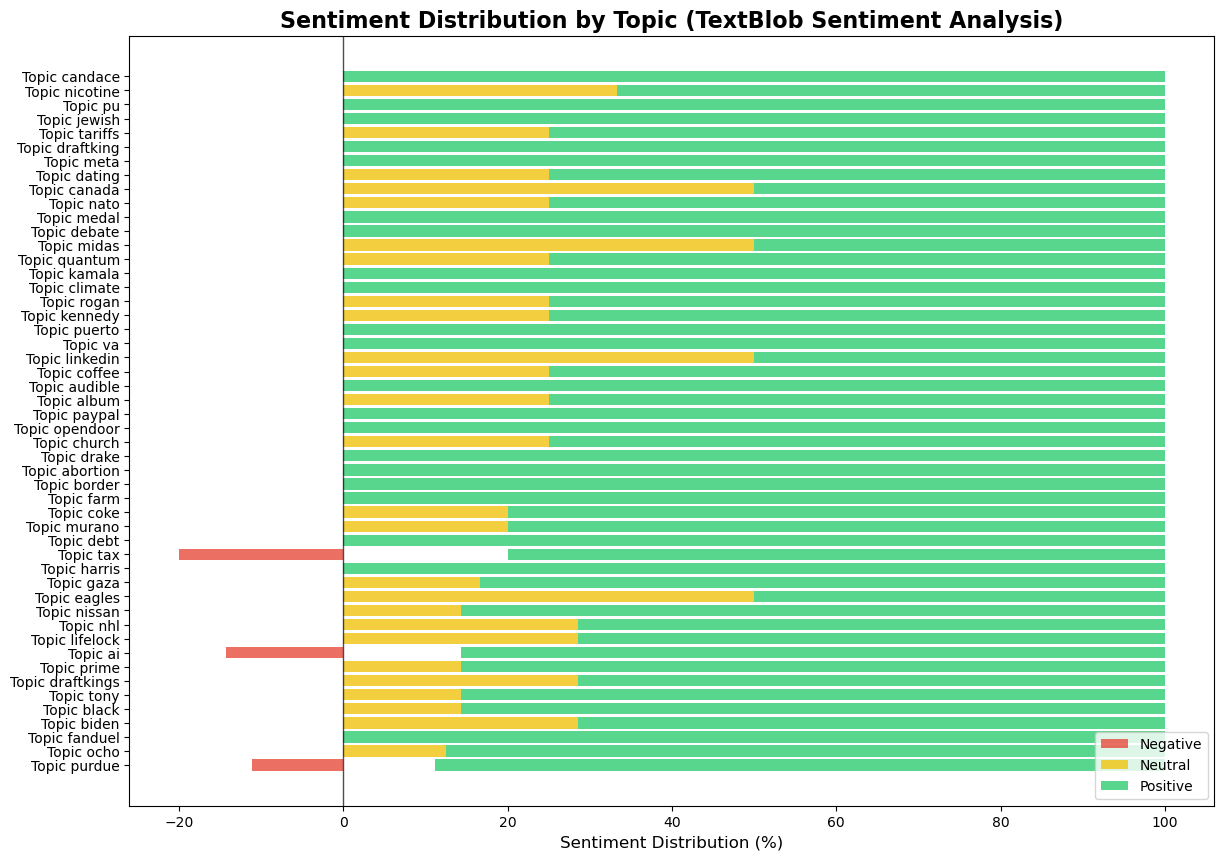

In [9]:
def textblob_diverging_stacked_bar(data, max_topics=50):

    data = data.head(max_topics)

    fig, ax = plt.subplots(figsize=(14, 10))



    negative = data.get('negative', pd.Series(0, index=data.index))
    neutral = data.get('neutral', pd.Series(0, index=data.index))
    positive = data.get('positive', pd.Series(0, index=data.index))

    y_pos = np.arange(len(data.index))

    bars1 = ax.barh(y_pos, -negative, color='#e74c3c', alpha=0.8, label='Negative')
    bars2 = ax.barh(y_pos, neutral, left=negative, color='#f1c40f', alpha=0.8, label='Neutral')
    bars3 = ax.barh(y_pos, positive, left=negative + neutral, color='#2ecc71', alpha=0.8, label='Positive')

    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"Topic {idx}" for idx in data.index], fontsize=10)
    ax.set_xlabel('Sentiment Distribution (%)', fontsize=12)
    ax.set_title('Sentiment Distribution by Topic (TextBlob Sentiment Analysis)', fontsize=16, fontweight='bold')
    ax.legend(loc='lower right')


    ax.axvline(0, color='black', linewidth=1, alpha=0.7)


    # return fig, ax

textblob_diverging_stacked_bar(sentiment_percentages)
plt.show()
    

    

    